## Install package

In [1]:
# %pip install torchinfo

In [2]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch import nn
from torchinfo import summary

import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from torch.cuda.amp import GradScaler, autocast

c:\Users\RUJUTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\RUJUTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
train_images_dir = "./ChangeDetection/Train/Images/T2019"
train_masks_dir = "./ChangeDetection/Train/Masks/T2019"

val_images_dir = "./ChangeDetection/Val/Images/T2019"
val_masks_dir = "./ChangeDetection/Val/Masks/T2019"

test_images_dir = "./ChangeDetection/Test/Images/T2019"
test_masks_dir = "./ChangeDetection/Test/Masks/T2019"

# classes = ["background", "grass", "densetree"]  # Define class names
classes = ["water", "building", "sparsetree","densetree"]

## Dataloader

In [4]:
class MultiClassDataset(Dataset):
    def __init__(self, x_dir, y_dir, classes, transform=None):
        """
        Args:
            x_dir (str): Path to the directory containing input images.
            y_dir (str): Path to the directory containing masks (multi-class).
            classes (list): List of class names.
            transform (callable, optional): Transform to apply to both image and mask.
        """
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.classes = classes
        self.num_classes = len(classes)
        self.transform = transform

        # Filter .tif files
        self.x_paths = sorted([f for f in os.listdir(x_dir) if f.endswith('.tif')])
        self.y_paths = sorted([f for f in os.listdir(y_dir) if f.endswith('.tif')])

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, index):
        # Load image and mask
        img_path = os.path.join(self.x_dir, self.x_paths[index])
        mask_path = os.path.join(self.y_dir, self.y_paths[index])

        image = Image.open(img_path)  # Load image without conversion
        mask = Image.open(mask_path)  # Load mask without conversion

        # Convert to NumPy arrays
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize image
        mask = np.array(mask, dtype=np.int64)  # Ensure mask is integer type

        # Apply transform if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Ensure image and mask are PyTorch tensors
        if isinstance(image, np.ndarray):
            if len(image.shape) == 3:  # Handle RGB images
                image = torch.from_numpy(image).permute(2, 0, 1)  # Convert HWC (height, width, col) to CHW
            else:  # Handle single-channel images
                image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension

        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)  # Mask remains H x W

        return image, mask


In [5]:
train_dataset = MultiClassDataset(
    train_images_dir,
    train_masks_dir,
    classes,
    #transform=no_augmentations(),
)

val_dataset = MultiClassDataset(
    val_images_dir,
    val_masks_dir,
    classes,
    #transform=no_augmentations(),
)

test_dataset = MultiClassDataset(
    test_images_dir,
    test_masks_dir,
    classes,
    #transform=no_augmentations(),
)

# Change to > 0 if not on Windows machine
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [6]:
def describe_loader(loader_type):
    print("batch size: ",loader_type.batch_size)
    print("shape: ", loader_type.dataset[0][0].shape, loader_type.dataset[0][1].shape)
    print(np.unique(loader_type.dataset[0][1]))
    print("number of images: ", len(loader_type.dataset))
    print("classes: ", loader_type.dataset.classes)

print("------------train------------")
describe_loader(train_loader)
print("------------val------------")
describe_loader(val_loader)
print("------------test------------")
describe_loader(test_loader)

------------train------------
batch size:  32
shape:  torch.Size([3, 256, 256]) torch.Size([256, 256])
[1 2 3]
number of images:  4280
classes:  ['water', 'building', 'sparsetree', 'densetree']
------------val------------
batch size:  32
shape:  torch.Size([3, 256, 256]) torch.Size([256, 256])
[1 2 3]
number of images:  920
classes:  ['water', 'building', 'sparsetree', 'densetree']
------------test------------
batch size:  32
shape:  torch.Size([3, 256, 256]) torch.Size([256, 256])
[1 2 3]
number of images:  920
classes:  ['water', 'building', 'sparsetree', 'densetree']


### View Dataloader

Unique values in the mask: [1 2 3]


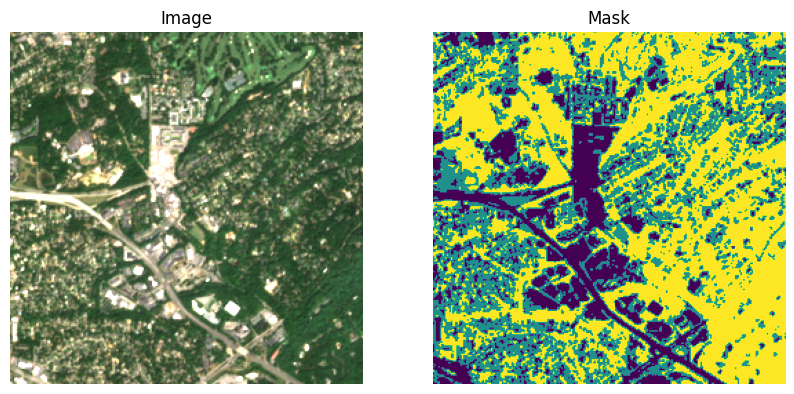

Unique values in the mask: [1 2 3]


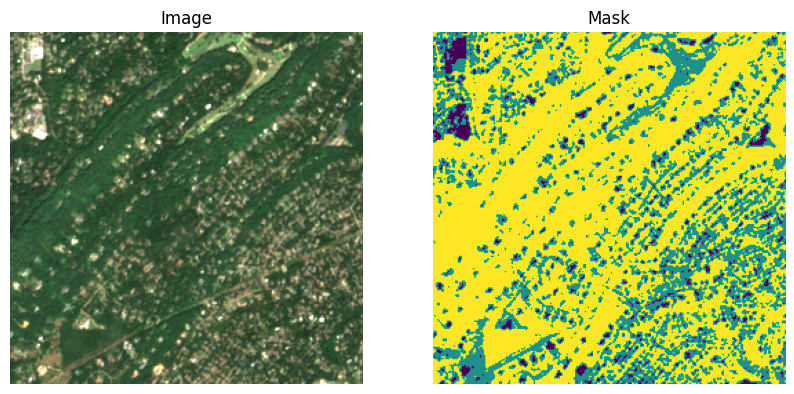

Unique values in the mask: [0 1 2 3]


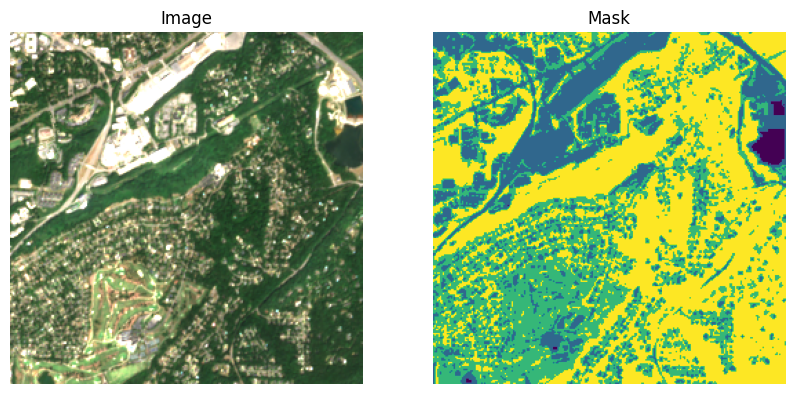

Unique values in the mask: [1 2 3]


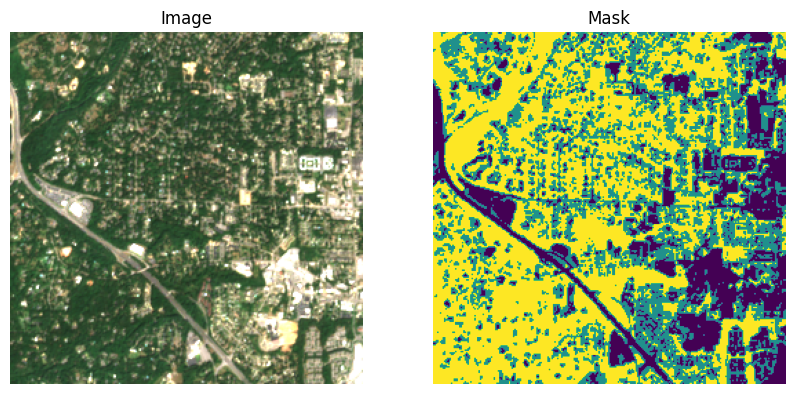

Unique values in the mask: [1 2 3]


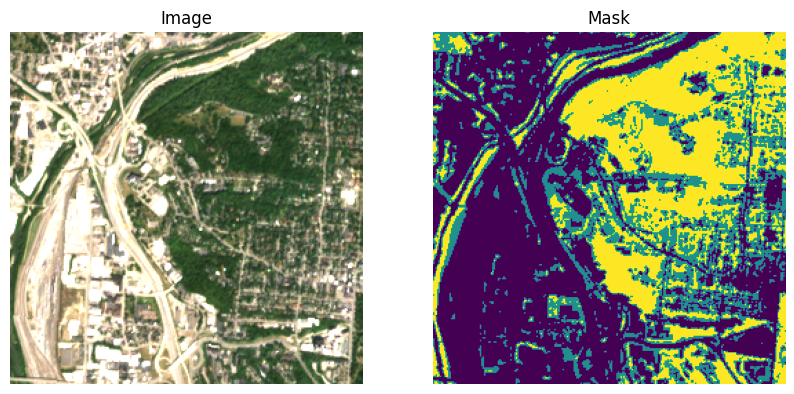

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(loader, index):
    """
    Visualizes a single image and its corresponding mask from the dataset loader.

    Args:
        loader (DataLoader): The dataset loader (train_loader, val_loader, or test_loader).
        index (int): Index of the image-mask pair to visualize.
    """
    # Access the dataset from the loader
    dataset = loader.dataset

    # Get the image and mask at the specified index
    image, mask = dataset[index]

    # Convert tensors to NumPy arrays for visualization
    image_np = image.permute(1, 2, 0).numpy()  # Convert CHW -> HWC
    mask_np = mask.numpy()

    print(f"Unique values in the mask: {np.unique(mask_np)}")

    # Plot the image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="viridis")
    plt.title("Mask")
    plt.axis("off")

    plt.show()

# Example usage:
for i in range(5):
    visualize_dataset(val_loader, index=i)  # Change index to view a different image


## Model

### DeepLabV3Plus

In [9]:
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['background', 'grass', 'densetree']
CLASSES = ['water','building', 'sparsetree', 'densetree']
ACTIVATION = 'sigmoid'
DEVICE = 'cpu'

# B,C,H,W = batch size, channels, height, width
# eg. (1, 3, 256, 256) = 1 image, 3 channels (RGB), 256x256 pixels

# mask should be (B, H, W)

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    in_channels=3,                 # Input image channels (e.g., RGB)
)
summary(model, (1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           [1, 4, 256, 256]          --
├─ResNetEncoder: 1-1                                    [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                                      [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                        [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                                   [1, 64, 64, 64]           --
│    └─Sequential: 2-5                                  [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                             [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                             [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                                  [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                     

## Training

### Model train

In [10]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
lr = 1e-4
batch_size = 16
num_classes = 4

# Training Function
def train_unet(model, train_loader, val_loader, checkpoint_path="checkpoint_epoch_{}.pth"):
    # Define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # To store loss and metric history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metrics': {'iou': [], 'f1': [], 'accuracy': [], 'recall': []},
        'val_metrics': {'iou': [], 'f1': [], 'accuracy': [], 'recall': []},
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_stats = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}

        # Training loop
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks.long())
            train_loss += loss.item()

            optimizer.zero_grad()

            # Compute stats for each batch
            preds = torch.argmax(outputs, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(preds.int(), masks.int(),
                                                   mode="multiclass",
                                                   num_classes=num_classes)
            train_stats['tp'] += tp.sum()
            train_stats['fp'] += fp.sum()
            train_stats['fn'] += fn.sum()
            train_stats['tn'] += tn.sum()

        # Calculate training metrics
        iou = smp.metrics.iou_score(train_stats['tp'], train_stats['fp'],
                                    train_stats['fn'], train_stats['tn'], reduction="micro")
        f1 = smp.metrics.f1_score(train_stats['tp'], train_stats['fp'],
                                    train_stats['fn'], train_stats['tn'], reduction="micro")
        accuracy = smp.metrics.accuracy(train_stats['tp'], train_stats['fp'],
                                    train_stats['fn'], train_stats['tn'], reduction="macro")
        recall = smp.metrics.recall(train_stats['tp'], train_stats['fp'],
                                    train_stats['fn'], train_stats['tn'], reduction="micro")

        # Log metrics
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        history['train_metrics']['iou'].append(iou)
        history['train_metrics']['f1'].append(f1)
        history['train_metrics']['accuracy'].append(accuracy)
        history['train_metrics']['recall'].append(recall)

        # Validation loop
        model.eval()
        val_loss = 0
        val_stats = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks.long())
                val_loss += loss.item()

                # Compute stats for each batch
                preds = torch.argmax(outputs, dim=1)
                tp, fp, fn, tn = smp.metrics.get_stats(preds.int(), masks.int(),
                                                       mode="multiclass",
                                                       num_classes=num_classes)
                val_stats['tp'] += tp.sum()
                val_stats['fp'] += fp.sum()
                val_stats['fn'] += fn.sum()
                val_stats['tn'] += tn.sum()

        # Calculate validation metrics
        iou = smp.metrics.iou_score(val_stats['tp'], val_stats['fp'],
                                    val_stats['fn'], val_stats['tn'], reduction="micro")
        f1 = smp.metrics.f1_score(val_stats['tp'], val_stats['fp'],
                                    val_stats['fn'], val_stats['tn'], reduction="micro")
        accuracy = smp.metrics.accuracy(val_stats['tp'], val_stats['fp'],
                                    val_stats['fn'], val_stats['tn'], reduction="macro")
        recall = smp.metrics.recall(val_stats['tp'], val_stats['fp'],
                                    val_stats['fn'], val_stats['tn'], reduction="micro")

        # Log metrics
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_metrics']['iou'].append(iou)
        history['val_metrics']['f1'].append(f1)
        history['val_metrics']['accuracy'].append(accuracy)
        history['val_metrics']['recall'].append(recall)

        # Adjust learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Metrics: IoU: {iou:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")
        print(f"Validation Metrics: IoU: {iou:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")

        # Save checkpoint
        checkpoint_file = checkpoint_path.format(epoch+1)
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Checkpoint saved at {checkpoint_file}")

    print("Training Complete")
    return model, history


In [11]:
trained_model, history = train_unet(model, train_loader, val_loader)

c:\Users\RUJUTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/20 [Validation]: 100%|██████████| 29/29 [06:02<00:00, 12.49s/it]


Epoch 1, Train Loss: 1.4003, Val Loss: 1.3966
Train Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Validation Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Checkpoint saved at checkpoint_epoch_1.pth


Epoch 2/20 [Validation]: 100%|██████████| 29/29 [05:34<00:00, 11.53s/it]


Epoch 2, Train Loss: 1.4004, Val Loss: 1.3965
Train Metrics: IoU: 0.1196, F1: 0.2136, Accuracy: 0.6068, Recall: 0.2136
Validation Metrics: IoU: 0.1196, F1: 0.2136, Accuracy: 0.6068, Recall: 0.2136
Checkpoint saved at checkpoint_epoch_2.pth


Epoch 3/20 [Validation]: 100%|██████████| 29/29 [05:13<00:00, 10.80s/it]


Epoch 3, Train Loss: 1.4003, Val Loss: 1.3964
Train Metrics: IoU: 0.1198, F1: 0.2140, Accuracy: 0.6070, Recall: 0.2140
Validation Metrics: IoU: 0.1198, F1: 0.2140, Accuracy: 0.6070, Recall: 0.2140
Checkpoint saved at checkpoint_epoch_3.pth


Epoch 4/20 [Validation]: 100%|██████████| 29/29 [05:45<00:00, 11.93s/it]


Epoch 4, Train Loss: 1.4003, Val Loss: 1.3966
Train Metrics: IoU: 0.1194, F1: 0.2133, Accuracy: 0.6067, Recall: 0.2133
Validation Metrics: IoU: 0.1194, F1: 0.2133, Accuracy: 0.6067, Recall: 0.2133
Checkpoint saved at checkpoint_epoch_4.pth


Epoch 5/20 [Validation]: 100%|██████████| 29/29 [04:04<00:00,  8.44s/it]


Epoch 5, Train Loss: 1.4002, Val Loss: 1.3966
Train Metrics: IoU: 0.1195, F1: 0.2135, Accuracy: 0.6068, Recall: 0.2135
Validation Metrics: IoU: 0.1195, F1: 0.2135, Accuracy: 0.6068, Recall: 0.2135
Checkpoint saved at checkpoint_epoch_5.pth


Epoch 6/20 [Validation]: 100%|██████████| 29/29 [03:27<00:00,  7.14s/it]


Epoch 6, Train Loss: 1.4003, Val Loss: 1.3966
Train Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Validation Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Checkpoint saved at checkpoint_epoch_6.pth


Epoch 7/20 [Validation]: 100%|██████████| 29/29 [03:45<00:00,  7.79s/it]


Epoch 7, Train Loss: 1.4002, Val Loss: 1.3965
Train Metrics: IoU: 0.1198, F1: 0.2139, Accuracy: 0.6069, Recall: 0.2139
Validation Metrics: IoU: 0.1198, F1: 0.2139, Accuracy: 0.6069, Recall: 0.2139
Checkpoint saved at checkpoint_epoch_7.pth


Epoch 8/20 [Validation]: 100%|██████████| 29/29 [03:20<00:00,  6.90s/it]


Epoch 8, Train Loss: 1.4003, Val Loss: 1.3965
Train Metrics: IoU: 0.1195, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Validation Metrics: IoU: 0.1195, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Checkpoint saved at checkpoint_epoch_8.pth


Epoch 9/20 [Validation]: 100%|██████████| 29/29 [03:16<00:00,  6.78s/it]


Epoch 9, Train Loss: 1.4003, Val Loss: 1.3964
Train Metrics: IoU: 0.1197, F1: 0.2139, Accuracy: 0.6069, Recall: 0.2139
Validation Metrics: IoU: 0.1197, F1: 0.2139, Accuracy: 0.6069, Recall: 0.2139
Checkpoint saved at checkpoint_epoch_9.pth


Epoch 10/20 [Validation]: 100%|██████████| 29/29 [03:10<00:00,  6.56s/it]


Epoch 10, Train Loss: 1.4003, Val Loss: 1.3966
Train Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Validation Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Checkpoint saved at checkpoint_epoch_10.pth


Epoch 11/20 [Validation]: 100%|██████████| 29/29 [03:12<00:00,  6.63s/it]


Epoch 11, Train Loss: 1.4003, Val Loss: 1.3966
Train Metrics: IoU: 0.1192, F1: 0.2130, Accuracy: 0.6065, Recall: 0.2130
Validation Metrics: IoU: 0.1192, F1: 0.2130, Accuracy: 0.6065, Recall: 0.2130
Checkpoint saved at checkpoint_epoch_11.pth


Epoch 12/20 [Validation]: 100%|██████████| 29/29 [03:13<00:00,  6.68s/it]


Epoch 12, Train Loss: 1.4003, Val Loss: 1.3965
Train Metrics: IoU: 0.1196, F1: 0.2137, Accuracy: 0.6068, Recall: 0.2137
Validation Metrics: IoU: 0.1196, F1: 0.2137, Accuracy: 0.6068, Recall: 0.2137
Checkpoint saved at checkpoint_epoch_12.pth


Epoch 13/20 [Validation]: 100%|██████████| 29/29 [03:12<00:00,  6.65s/it]


Epoch 13, Train Loss: 1.4003, Val Loss: 1.3964
Train Metrics: IoU: 0.1198, F1: 0.2139, Accuracy: 0.6070, Recall: 0.2139
Validation Metrics: IoU: 0.1198, F1: 0.2139, Accuracy: 0.6070, Recall: 0.2139
Checkpoint saved at checkpoint_epoch_13.pth


Epoch 14/20 [Validation]: 100%|██████████| 29/29 [03:11<00:00,  6.60s/it]


Epoch 14, Train Loss: 1.4004, Val Loss: 1.3966
Train Metrics: IoU: 0.1192, F1: 0.2130, Accuracy: 0.6065, Recall: 0.2130
Validation Metrics: IoU: 0.1192, F1: 0.2130, Accuracy: 0.6065, Recall: 0.2130
Checkpoint saved at checkpoint_epoch_14.pth


Epoch 15/20 [Validation]: 100%|██████████| 29/29 [03:13<00:00,  6.68s/it]


Epoch 15, Train Loss: 1.4003, Val Loss: 1.3965
Train Metrics: IoU: 0.1195, F1: 0.2136, Accuracy: 0.6068, Recall: 0.2136
Validation Metrics: IoU: 0.1195, F1: 0.2136, Accuracy: 0.6068, Recall: 0.2136
Checkpoint saved at checkpoint_epoch_15.pth


Epoch 16/20 [Validation]: 100%|██████████| 29/29 [03:24<00:00,  7.06s/it]


Epoch 16, Train Loss: 1.4002, Val Loss: 1.3966
Train Metrics: IoU: 0.1192, F1: 0.2130, Accuracy: 0.6065, Recall: 0.2130
Validation Metrics: IoU: 0.1192, F1: 0.2130, Accuracy: 0.6065, Recall: 0.2130
Checkpoint saved at checkpoint_epoch_16.pth


Epoch 17/20 [Validation]: 100%|██████████| 29/29 [03:10<00:00,  6.56s/it]


Epoch 17, Train Loss: 1.4002, Val Loss: 1.3966
Train Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Validation Metrics: IoU: 0.1194, F1: 0.2134, Accuracy: 0.6067, Recall: 0.2134
Checkpoint saved at checkpoint_epoch_17.pth


Epoch 18/20 [Validation]: 100%|██████████| 29/29 [03:08<00:00,  6.51s/it]


Epoch 18, Train Loss: 1.4003, Val Loss: 1.3965
Train Metrics: IoU: 0.1195, F1: 0.2135, Accuracy: 0.6067, Recall: 0.2135
Validation Metrics: IoU: 0.1195, F1: 0.2135, Accuracy: 0.6067, Recall: 0.2135
Checkpoint saved at checkpoint_epoch_18.pth


Epoch 19/20 [Validation]: 100%|██████████| 29/29 [03:10<00:00,  6.57s/it]


Epoch 19, Train Loss: 1.4003, Val Loss: 1.3966
Train Metrics: IoU: 0.1196, F1: 0.2137, Accuracy: 0.6068, Recall: 0.2137
Validation Metrics: IoU: 0.1196, F1: 0.2137, Accuracy: 0.6068, Recall: 0.2137
Checkpoint saved at checkpoint_epoch_19.pth


Epoch 20/20 [Validation]: 100%|██████████| 29/29 [03:09<00:00,  6.52s/it]


Epoch 20, Train Loss: 1.4003, Val Loss: 1.3965
Train Metrics: IoU: 0.1196, F1: 0.2137, Accuracy: 0.6068, Recall: 0.2137
Validation Metrics: IoU: 0.1196, F1: 0.2137, Accuracy: 0.6068, Recall: 0.2137
Checkpoint saved at checkpoint_epoch_20.pth
Training Complete


### Save + Load + Evaluate model

In [12]:
# Save and Load Functions
def save_model(model, path="unet_model.pth"):
    torch.save(model.state_dict(), path)

def load_model(model, path="unet_model.pth"):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    return model

# Evaluate Model with Metrics
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_stats = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating on Test Data"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, masks.long())
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(preds.int(), masks.int(),
                                                   mode="multiclass", num_classes=num_classes)
            test_stats['tp'] += tp.sum()
            test_stats['fp'] += fp.sum()
            test_stats['fn'] += fn.sum()
            test_stats['tn'] += tn.sum()

    # Calculate test metrics
    iou = smp.metrics.iou_score(test_stats['tp'], test_stats['fp'],
                                test_stats['fn'], test_stats['tn'], reduction="micro")
    f1 = smp.metrics.f1_score(test_stats['tp'], test_stats['fp'],
                                test_stats['fn'], test_stats['tn'], reduction="micro")
    accuracy = smp.metrics.accuracy(test_stats['tp'], test_stats['fp'],
                                test_stats['fn'], test_stats['tn'], reduction="macro")
    recall = smp.metrics.recall(test_stats['tp'], test_stats['fp'],
                                test_stats['fn'], test_stats['tn'], reduction="micro")

    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Metrics: IoU: {iou:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")


In [13]:
save_model(trained_model, "unet_model.pth")
model = load_model(model, "unet_model.pth")
evaluate_model(model, test_loader)

Evaluating on Test Data: 100%|██████████| 29/29 [03:13<00:00,  6.68s/it]

Test Loss: 1.3951
Test Metrics: IoU: 0.1268, F1: 0.2251, Accuracy: 0.6126, Recall: 0.2251


## View segmentation

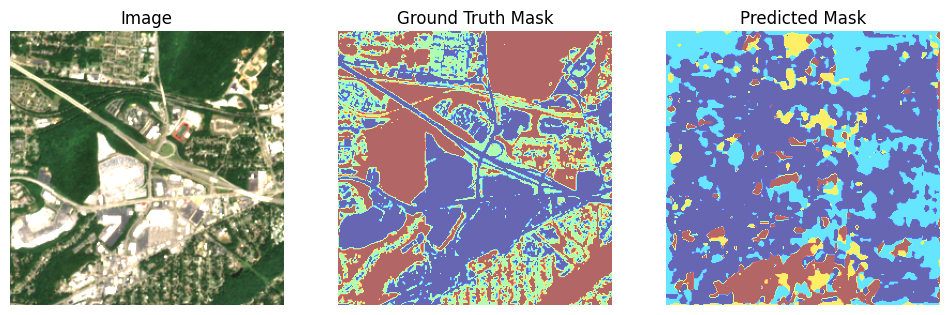

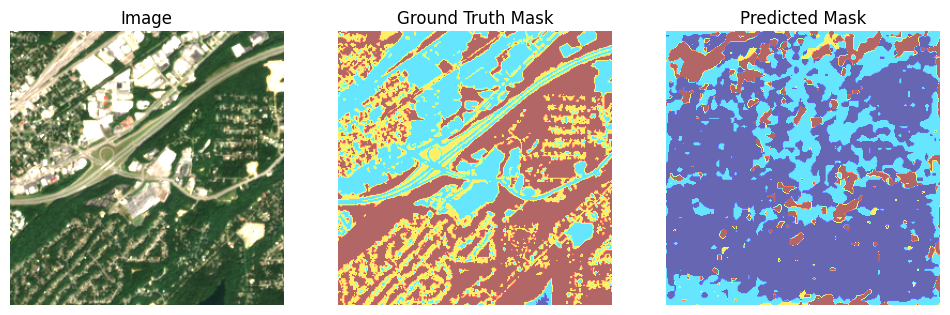

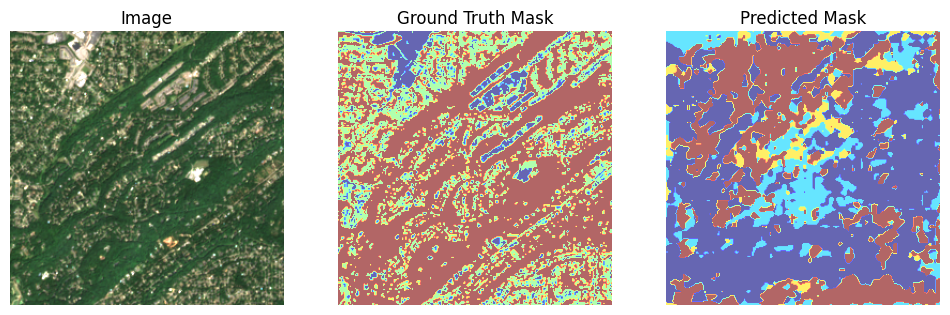

In [14]:
# Display images, generated segmentations, and masks
def display_segmentation(model, data_loader, num_images=3):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                image = images[i].cpu().permute(1, 2, 0).numpy()
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(image)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth Mask")
                plt.imshow(mask, cmap="jet", alpha=0.6)
                plt.axis('off')
                #print(np.unique(mask))

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(pred, cmap="jet", alpha=0.6)
                plt.axis('off')
                #print(np.unique(pred))

                plt.show()

                images_shown += 1

display_segmentation(model, test_loader)